Importing necessary packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

Importing files

In [3]:
train_dataset = pd.read_csv("E://Jupyter//Kaggle//3.learn-together//data//train.csv")
test_dataset = pd.read_csv("E://Jupyter//Kaggle//3.learn-together//data//test.csv")

In [4]:
train_dataset.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


# I. Understand the problem

Data Type: Tabluar data

Problem Type: Classification

Competition Metric: Categorization Accuracy. I think basically it is percentage of correct predictions

In [5]:
# Set seed
SEED = 42

In [11]:
def evaluate_metric_score(y_true, y_pred):
    if y_true.shape[0] != y_pred.shape[0]:
        raise Exception("Sizes do not match")
        return 0
    else:
        size = y_true.shape[0]
        matches = 0
        y_true_array = np.array(list(y_true))
        y_pred_array = np.array(list(y_pred))
        for i in range(0,size):
            if y_true_array[i]==y_pred_array[i]:
                matches = matches + 1
        return matches/size

In [12]:
def custom_cross_validation_score(model, train_dataset, num_fold=5, shuffle=True, random_state=SEED):

    sum_model =0
    skfold = StratifiedKFold(n_splits=num_fold, shuffle=shuffle, random_state=random_state)
    for cv_train_index, cv_test_index in skfold.split(train_dataset.iloc[:,:-1],train_dataset.iloc[:,-1]):
        cv_train_dataset = train_dataset.iloc[cv_train_index]
        cv_test_dataset = train_dataset.iloc[cv_test_index]
        model.fit(cv_train_dataset.iloc[:,:-1],cv_train_dataset.iloc[:,-1])
        preds = model.predict(cv_test_dataset.iloc[:,:-1])
        actuals = np.array(cv_test_dataset.iloc[:,-1])
        sum_model = sum_model + evaluate_metric_score(actuals,preds)
    
    return(sum_model/num_fold)

In [13]:
class baselinemodel1:
    def __init__(self, modelname):
        self.modelname = modelname
    
    def fit(self, train, target, value):
        self.value = value
    
    def predict(self, test):
        resultdf = test.copy()
        resultdf['Cover_Type'] = 4
        return resultdf['Cover_Type']

# II. Initial EDA

Goals of EDA:
1. Size of the data
2. Properties of the target variable (check for issues like high class imbalance, skewed distribution in a regression)
3. Properties of the features: Finding some peculirarities and dependencies between features and target variable is always useful
4. Generate ideas for feature engineering and future hypothesis

In [6]:
train_dataset.shape

(15120, 56)

In [7]:
test_dataset.shape

(565892, 55)

In [8]:
X = train_dataset.copy()
X = X.drop(columns=['Cover_Type'])
y = train_dataset[['Cover_Type']]

In [9]:
X.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,0
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,0
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,0
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,0
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [11]:
train_dataset.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [12]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

In [13]:
test_dataset.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,...,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000,565892.000000
mean,298066.500000,2964.977407,155.629558,14.039635,270.556622,46.294408,2367.143116,212.131133,223.435026,142.726951,...,0.044768,0.091588,0.078704,0.002808,0.003161,0.000193,0.000467,0.026233,0.023236,0.014651
std,163359.093603,273.157030,111.962120,7.450155,212.500153,58.209469,1561.482002,26.661063,19.668053,38.030094,...,0.206795,0.288444,0.269277,0.052916,0.056137,0.013877,0.021594,0.159827,0.150652,0.120152
min,15121.000000,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,156593.750000,2818.000000,58.000000,9.000000,108.000000,7.000000,1116.000000,198.000000,213.000000,119.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,298066.500000,2999.000000,127.000000,13.000000,228.000000,29.000000,2018.000000,218.000000,226.000000,143.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,439539.250000,3164.000000,260.000000,18.000000,390.000000,69.000000,3349.000000,231.000000,237.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,581012.000000,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565892 entries, 0 to 565891
Data columns (total 55 columns):
Id                                    565892 non-null int64
Elevation                             565892 non-null int64
Aspect                                565892 non-null int64
Slope                                 565892 non-null int64
Horizontal_Distance_To_Hydrology      565892 non-null int64
Vertical_Distance_To_Hydrology        565892 non-null int64
Horizontal_Distance_To_Roadways       565892 non-null int64
Hillshade_9am                         565892 non-null int64
Hillshade_Noon                        565892 non-null int64
Hillshade_3pm                         565892 non-null int64
Horizontal_Distance_To_Fire_Points    565892 non-null int64
Wilderness_Area1                      565892 non-null int64
Wilderness_Area2                      565892 non-null int64
Wilderness_Area3                      565892 non-null int64
Wilderness_Area4                      565892 non-

.describe() & .info() gave the constant count at 15120 (train dataset) and 565892 (test dataset) across all columns
Thus no null values

In [15]:
y['Cover_Type'].value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

=> There is an equal class distribution

Checking 'Id' Column whether it is unique with entries

In [16]:
len(X['Id'].unique()) == len(X)

True

### Based on description: 

#### Below columns seem to have numeric continuous data 
'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Horizontal_Distance_To_Fire_Points'


#### Below columns seem to have categorical data 
Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

In [17]:
list_contfeatures=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Horizontal_Distance_To_Fire_Points']

In [19]:
check = train_dataset.copy()
check_test = test_dataset.copy()

In [20]:
#Setting values to string type
check['Cover_Type']=check['Cover_Type'].astype(str)

#### Confirmed every 30mx30m belongs to only one Wildereness_Area
Now next to Soil_Type

#### Confirmed every 30mx30m contains only one Soil Type

Lets create 2 columns for:
    1. 4 feature columns corresponding to Wilderness Areas (naming it 'Wilderness_Area')
    2. 40 feature columns corresponding to Soil Types (naming it 'Soil_Type')
=> In essence we have to analyze these categorical features (compressing 44 cols to 2 cols).This will prove useful when for EDA purposes
However for model building we preserve the one-hot encoded features

In [28]:
str1="Wilderness_Area"
for i in range(1,5):
    str2=str1+str(i)
    check.loc[(check[str2]==1),str1]=str2
    check_test.loc[(check_test[str2]==1),str1]=str2

In [29]:
#Lets check the uniqueness - should have only 4 categories
check['Wilderness_Area'].unique()

array(['Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4',
       'Wilderness_Area2'], dtype=object)

In [30]:
check_test['Wilderness_Area'].unique()

array(['Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4',
       'Wilderness_Area2'], dtype=object)

In [31]:
str1="Soil_Type"
not_present =[]
for i in range(1,41):
    str2=str1+str(i)
    check.loc[(check[str2]==1),str1] = str2
    if len(check.loc[(check[str2]==1),str1]) ==0:
        not_present.append(str2)
    check_test.loc[(check_test[str2]==1),str1]=str2

In [32]:
check['Soil_Type'].unique()

array(['Soil_Type29', 'Soil_Type12', 'Soil_Type30', 'Soil_Type18',
       'Soil_Type16', 'Soil_Type20', 'Soil_Type24', 'Soil_Type23',
       'Soil_Type40', 'Soil_Type19', 'Soil_Type8', 'Soil_Type22',
       'Soil_Type39', 'Soil_Type9', 'Soil_Type38', 'Soil_Type33',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type11', 'Soil_Type10',
       'Soil_Type5', 'Soil_Type28', 'Soil_Type4', 'Soil_Type1',
       'Soil_Type13', 'Soil_Type2', 'Soil_Type17', 'Soil_Type3',
       'Soil_Type34', 'Soil_Type6', 'Soil_Type14', 'Soil_Type37',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type21', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type25'], dtype=object)

In [33]:
not_present

['Soil_Type7', 'Soil_Type15']

Soil types 7 & 15 are absent in train dataset

### Baseline Model 1

To create first baseline model, lets first check number of entries in dataset

In [39]:
len(test_dataset)%7

5

Hoped it would be divisible by 7, which could help us assume equally distributed classes even within test dataset.
Since train datset has equal class distribution, lets randomly pick a class say 4 and build predictions based on this

In [14]:
# Lets build the validation pipeline by instantiating the Stratified KFold:
num_fold = 5
s_kfold = StratifiedKFold(n_splits=num_fold, shuffle = True, random_state=True)

In [15]:
#List of the results
fold_metrics_bm1 = []
mean_cv_metrics = 0 
for train_index, test_index in s_kfold.split(train_dataset, train_dataset['Cover_Type']):
    cv_train, cv_test = train_dataset.iloc[train_index], train_dataset.iloc[test_index]
    # Train the model like model.fit(cv_train.loc[:,cv_train.columns != 'Cover_Type'],cv_train[['cv_train']])
    bm1 = baselinemodel1("Baselinemodel1")
    bm1.fit(cv_train.loc[:,cv_train.columns != 'Cover_Type'], cv_train[['Cover_Type']],4)
    y_pred = bm1.predict(cv_test.loc[:,cv_test.columns != 'Cover_Type'])
    y_actual = cv_test['Cover_Type']
    fold_metrics_bm1.append(evaluate_metric_score(y_actual, y_pred))
    
sum_cv_metrics = 0
for i in fold_metrics_bm1:
    sum_cv_metrics = sum_cv_metrics + i
mean_cv_metrics = sum_cv_metrics/num_fold

In [16]:
mean_cv_metrics

0.14285714285714285

In [152]:
test_dataset['bm1'] = 4

In [169]:
submission1 = pd.DataFrame({'Id':test_dataset.Id, 'Cover_Type':test_dataset.bm1})

In [171]:
submission1.set_index('Id').to_csv("E://Jupyter//Kaggle//3.learn-together//output files//submission1.csv")

In [194]:
test_dataset=test_dataset.drop(columns=['bm1'])

#### Score after submission of baseline model 1:  0.00106
#### Our cross validation score for baseline model 1: 0.1428

This time picking a class say 1 and build predictions based on this => which is our sample submission


In [17]:
# Lets build the validation pipeline by instantiating the Stratified KFold:
num_fold = 5
#s_kfold = StratifiedKFold(n_splits=num_fold, shuffle = True, random_state=True)

In [18]:
#List of the results
fold_metrics_bm2 = []
for train_index, test_index in s_kfold.split(train_dataset, train_dataset['Cover_Type']):
    cv_train, cv_test = train_dataset.iloc[train_index], train_dataset.iloc[test_index]
    # Train the model like model.fit(cv_train.loc[:,cv_train.columns != 'Cover_Type'],cv_train[['cv_train']])
    bm2 = baselinemodel1("Baselinemodel2")
    bm2.fit(cv_train.loc[:,cv_train.columns != 'Cover_Type'], cv_train[['Cover_Type']],1)
    y_pred = bm2.predict(cv_test.loc[:,cv_test.columns != 'Cover_Type'])
    y_actual = cv_test['Cover_Type']
    fold_metrics_bm1.append(evaluate_metric_score(y_actual, y_pred))
    
sum_cv_metrics = 0
for i in fold_metrics_bm1:
    sum_cv_metrics = sum_cv_metrics + i
mean_cv_metrics = sum_cv_metrics/num_fold

In [19]:
mean_cv_metrics

0.28571428571428564

#### Score after submission of baseline model#2:  0.37053
#### Our cross validation score for baseline model#2: 0.2857

#### We have baseline models in place, now lets start with model building

### Model 1: Starting with Decision Tree

#### Modelling a Decision Tree with 5 trees

In [20]:
dt_1 = DecisionTreeClassifier(max_depth=5, random_state=SEED)

In [22]:
custom_cross_validation_score(model=dt_1,train_dataset=train_dataset, num_fold=5, shuffle=True, random_state=SEED)

0.661441798941799

In [25]:
predictions_dt_1 = dt_1.predict(test_dataset)

In [26]:
submission2 = pd.DataFrame({'Id':test_dataset.Id, 'Cover_Type':predictions_dt_1}).set_index('Id')

In [27]:
submission2.to_csv("E://Jupyter//Kaggle//3.learn-together//output files//submission2.csv")

In [28]:
dt_1.feature_importances_

array([0.02813992, 0.72942518, 0.00269751, 0.00277241, 0.02571914,
       0.        , 0.02779752, 0.06327956, 0.        , 0.        ,
       0.01447598, 0.02833307, 0.        , 0.00429848, 0.        ,
       0.        , 0.        , 0.00645934, 0.02365928, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01243404,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00742707, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00470701, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00750108, 0.01087341, 0.        ])

In [30]:
df_fi_dt_1 = pd.DataFrame({'features':test_dataset.columns,'importance_metric':dt_1.feature_importances_})

In [32]:
df_fi_dt_1 = df_fi_dt_1.sort_values(['importance_metric'],ascending=False)

In [33]:
df_fi_dt_1.head()

,features,importance_metric
1,Elevation,0.729425
7,Hillshade_9am,0.063280
11,Wilderness_Area1,0.028333
0,Id,0.028140
6,Horizontal_Distance_To_Roadways,0.027798


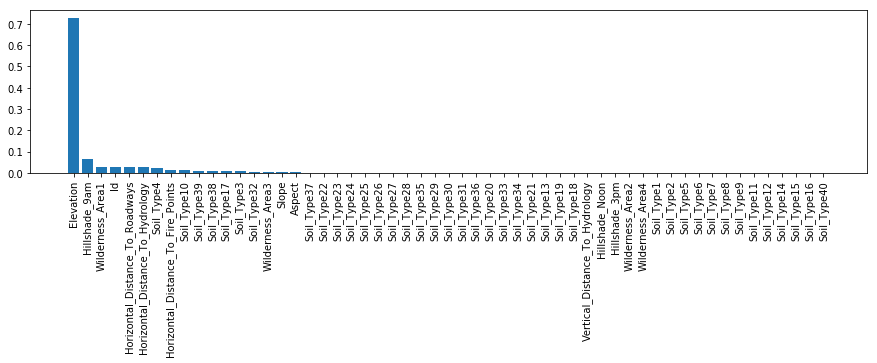

In [37]:
fig,ax = plt.subplots()
ax.bar(df_fi_dt_1['features'],df_fi_dt_1['importance_metric'])
fig.set_size_inches([15,3])
plt.xticks(rotation=90)
plt.show()

### Model 1: Now with Decision Tree (using CV Grid)

In [38]:
dt_1.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

In [44]:
params_dt = {
    'max_depth': [9,50, 100, 150, 200],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}

In [45]:
dt_model = DecisionTreeClassifier(random_state=SEED)

In [46]:
grid_dt = GridSearchCV(estimator=dt_model, param_grid=params_dt,cv=5, n_jobs=-1)

In [47]:
grid_dt.fit(train_dataset.loc[:,train_dataset.columns!='Cover_Type'],train_dataset[['Cover_Type']])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [9, 50, 100, 150, 200], 'min_samples_leaf': [0.04, 0.06, 0.08], 'max_features': [0.2, 0.4, 0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
grid_dt.best_params_

{'max_depth': 9, 'max_features': 1.0, 'min_samples_leaf': 0.04}

In [49]:
grid_dt.best_score_

0.59755291005291

In [50]:
grid_dt.best_estimator_.feature_importances_

array([0.01050551, 0.79506951, 0.        , 0.        , 0.01764412,
       0.01508495, 0.01373771, 0.06542124, 0.        , 0.        ,
       0.02799863, 0.        , 0.        , 0.00225709, 0.        ,
       0.        , 0.        , 0.0253665 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02691474,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [51]:
df_fi2 = pd.DataFrame({'features':test_dataset.columns,'importance_values':grid_dt.best_estimator_.feature_importances_})

In [52]:
df_fi2 = df_fi2.sort_values(['importance_values'],ascending=False)

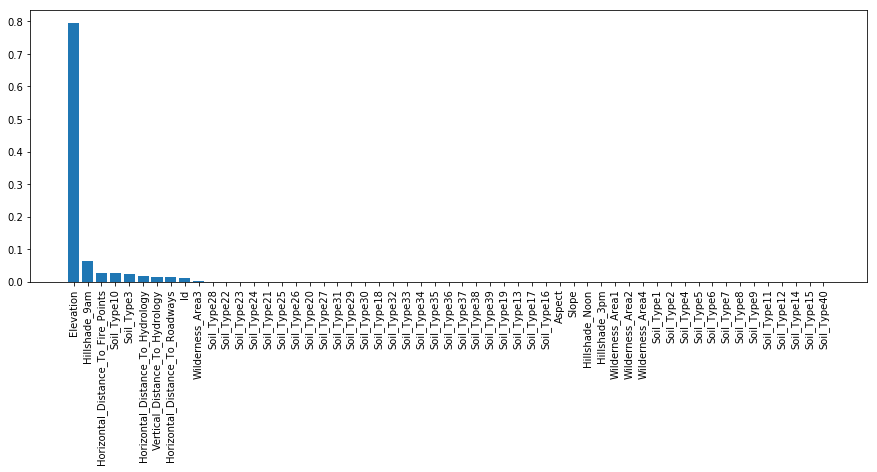

In [54]:
fig,ax = plt.subplots()
ax.bar(df_fi2['features'],df_fi2['importance_values'])
fig.set_size_inches([15,5])
plt.xticks(rotation=90)
plt.show()


In [374]:
predictions3 = grid_dt.best_estimator_.predict(test_dataset) 

In [377]:
grid_dt.best_params_

{'max_depth': 9, 'max_features': 0.6, 'min_samples_leaf': 0.04}

In [375]:
submission3 = pd.DataFrame({'Id':test_dataset.Id,'Cover_Type':predictions3}).set_index('Id')

In [376]:
submission3.to_csv("E://Jupyter//Kaggle//3.learn-together//output files//submission3.csv")

In [55]:
custom_cross_validation_score(grid_dt.best_estimator_,train_dataset)

0.6326719576719577

In [56]:
# Saving output for ensembling
model1_train_predictions = grid_dt.best_estimator_.predict(train_dataset.iloc[:,:-1])

In [96]:
model1_test_predictions = grid_dt.best_estimator_.predict(test_dataset)

### Model 2: Random Forest Trees

In [57]:
rf = RandomForestClassifier(n_estimators = 100, random_state=SEED)

In [58]:
custom_cross_validation_score(model=rf,train_dataset=train_dataset)

0.8685185185185185

In [59]:
rf.feature_importances_

array([7.86826879e-02, 2.09767507e-01, 4.39210701e-02, 3.26342983e-02,
       5.48718292e-02, 4.98718411e-02, 8.55395735e-02, 4.83649004e-02,
       4.05129736e-02, 4.14028122e-02, 6.41189686e-02, 1.65290048e-02,
       3.03655315e-03, 1.59730503e-02, 4.56978770e-02, 1.25927181e-03,
       5.81526695e-03, 1.91006562e-02, 1.33535813e-02, 1.20734426e-03,
       2.48224146e-03, 0.00000000e+00, 3.33784150e-06, 4.28038780e-05,
       2.23466946e-02, 3.02639847e-03, 4.53343262e-03, 4.76869509e-03,
       6.03745742e-04, 0.00000000e+00, 1.01084799e-03, 6.04472300e-03,
       5.99118157e-04, 3.08076165e-04, 1.50500093e-03, 2.08779542e-04,
       4.68844159e-03, 5.31675573e-03, 2.14531748e-03, 2.05787099e-05,
       3.70282432e-04, 1.45204907e-04, 1.48928918e-04, 5.16210976e-03,
       8.79179399e-03, 2.30684983e-03, 4.35665369e-03, 3.58422887e-03,
       2.74509204e-04, 1.94511227e-03, 6.35195955e-05, 4.58258934e-04,
       1.58379979e-02, 1.57562262e-02, 9.48226690e-03])

In [60]:
df_fi3 = pd.DataFrame({'Features':test_dataset.columns,'Importance Scores':rf.feature_importances_})
df_fi3 = df_fi3.sort_values(['Importance Scores'],ascending=False)

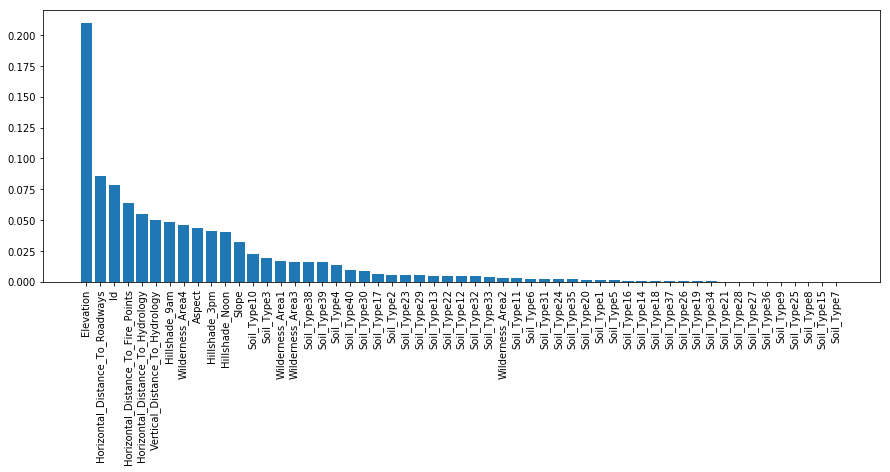

In [61]:
fig,ax = plt.subplots()
ax.bar(df_fi3['Features'],df_fi3['Importance Scores'])
fig.set_size_inches([15,5])
plt.xticks(rotation=90)
plt.show()

### Model 6: RandomForest (Using hyperparameter optimization)

In [65]:
# Lets build the validation pipeline by instantiating the Stratified KFold:
num_fold = 5
params_rf1 = list(np.arange(410,500,10))
score_dict = {}
for n_estimators in params_rf1:
    s_kfold = StratifiedKFold(n_splits=num_fold, shuffle = True, random_state=True)
    sum_dt = 0
    rf = RandomForestClassifier(n_estimators = n_estimators, random_state=SEED)
    for train_index,test_index in s_kfold.split(train_dataset,train_dataset['Cover_Type']):
        cv_train, cv_test = train_dataset.iloc[train_index], train_dataset.iloc[test_index]
        y_train_dataset, y_test_dataset = train_dataset[['Cover_Type']].iloc[train_index], train_dataset[['Cover_Type']].iloc[test_index]
        rf.fit(cv_train.loc[:,cv_train.columns!='Cover_Type'], y_train_dataset)

        y_pred = rf.predict(cv_test.loc[:,cv_test.columns!='Cover_Type'])
        y_actual = np.array(y_test_dataset['Cover_Type'])

        sum_dt = sum_dt + evaluate_metric_score(y_actual,y_pred)
    val_score = sum_dt/num_fold
    score_dict[n_estimators] = val_score

C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

In [394]:
score_dict_iteration1 = score_dict

In [395]:
score_dict_iteration1

{100: 0.870304232804233,
 150: 0.8716931216931216,
 200: 0.8714285714285713,
 300: 0.8716931216931216,
 350: 0.8725529100529099}

In [397]:
score_dict

{400: 0.8723544973544973,
 450: 0.8717592592592593,
 500: 0.8728174603174603,
 550: 0.8718253968253968,
 600: 0.8726190476190476,
 650: 0.8724867724867724,
 700: 0.8723544973544974}

In [66]:
score_dict

{410: 0.872089947089947,
 420: 0.8726190476190476,
 430: 0.8724867724867724,
 440: 0.8720238095238095,
 450: 0.8717592592592593,
 460: 0.8724867724867724,
 470: 0.8724206349206348,
 480: 0.8723544973544974,
 490: 0.8727513227513228}

In [67]:
rf2 = RandomForestClassifier(n_estimators=500, random_state=SEED)

In [68]:
rf2.fit(train_dataset.loc[:,train_dataset.columns!='Cover_Type'],train_dataset[['Cover_Type']])

C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [78]:
# Saving for ensemble
model2_train_predictions = rf2.predict(train_dataset.iloc[:,:-1])

In [94]:
model2_test_predictions = rf2.predict(test_dataset)

In [69]:
predictions4 = rf2.predict(test_dataset)

In [79]:
submission4 = pd.DataFrame({'Id':test_dataset.Id, 'Cover_type':predictions4}).set_index('Id')
submission4.to_csv("E://Jupyter//Kaggle//3.learn-together//output files//submission4.csv")

In [403]:
df_fi4 = pd.DataFrame({'Features':test_dataset.columns,'Importance Scores':rf2.feature_importances_})

In [404]:
df_fi4 = df_fi4.sort_values(['Importance Scores'],ascending=False)

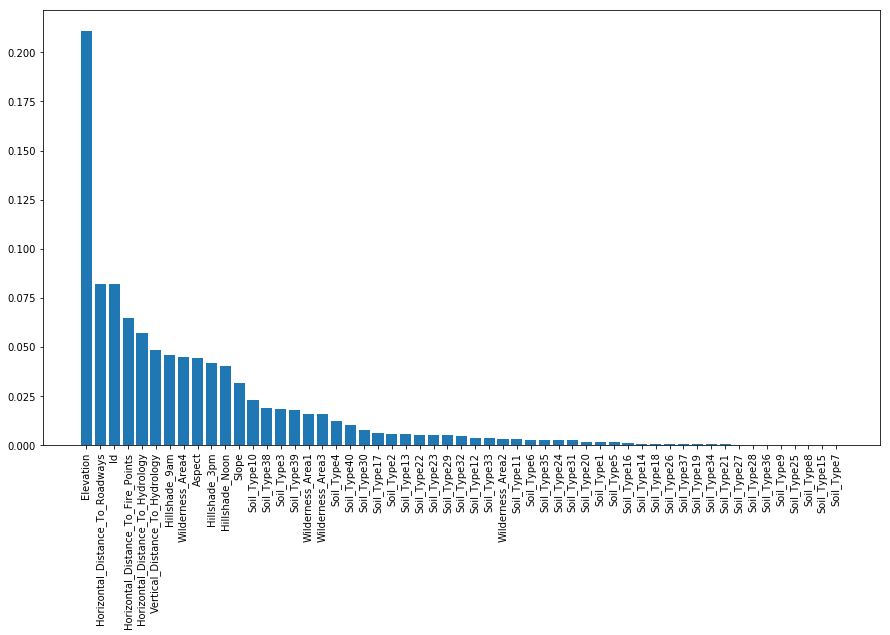

In [405]:
fig,ax = plt.subplots()
ax.bar(df_fi4['Features'], df_fi4['Importance Scores'])
fig.set_size_inches([15,8])
plt.xticks(rotation=90)
plt.show()

### Model 7: Using XGBoost

In [435]:
xgb1 = XGBClassifier()

In [436]:
xgb1.fit(train_dataset.loc[:,train_dataset.columns!='Cover_Type'],train_dataset['Cover_Type'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [437]:
res = xgb1.predict(test_dataset)

In [445]:
# Lets build the validation pipeline by instantiating the Stratified KFold:
num_fold = 5
params_xgb1 = [600]
score_dict = {}
for n_estimators in params_xgb1:
    s_kfold = StratifiedKFold(n_splits=num_fold, shuffle = True, random_state=True)
    sum_dt = 0
    xgb1 = XGBClassifier(n_estimators = n_estimators)
    for train_index,test_index in s_kfold.split(train_dataset,train_dataset['Cover_Type']):
        cv_train, cv_test = train_dataset.iloc[train_index], train_dataset.iloc[test_index]
        y_train_dataset, y_test_dataset = train_dataset[['Cover_Type']].iloc[train_index], train_dataset[['Cover_Type']].iloc[test_index]
        xgb1.fit(cv_train.loc[:,cv_train.columns!='Cover_Type'], y_train_dataset)

        y_pred = xgb1.predict(cv_test.loc[:,cv_test.columns!='Cover_Type'])
        y_actual = np.array(y_test_dataset['Cover_Type'])

        sum_dt = sum_dt + evaluate_metric_score(y_actual,y_pred)
    val_score = sum_dt/num_fold
    score_dict[n_estimators] = val_score

C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sscaria\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversio

In [440]:
sum_dt/num_fold

0.7681878306878307

In [443]:
score_dict_iteration1 = score_dict

In [444]:
score_dict_iteration1

{100: 0.7681878306878307,
 150: 0.7949074074074074,
 200: 0.8081349206349208,
 250: 0.8179232804232803,
 300: 0.8253968253968254,
 350: 0.8319444444444443,
 400: 0.8376984126984126,
 450: 0.8429232804232804,
 500: 0.8466931216931217}

In [446]:
score_dict

{1000: 0.8634259259259259, 1200: 0.8664682539682541}

### Creating Ensembles

In [71]:
meta_train_dataset = train_dataset.copy()

In [139]:
firstlevel_models_predictions_train_dataset = pd.DataFrame({'Model1':model1_train_predictions, 'Model2':model2_train_predictions, 'Cover_Type':train_dataset.Cover_Type})

In [138]:
firstlevel_models_predictions_test_dataset = pd.DataFrame({'Model1':model1_test_predictions, 'Model2':model2_test_predictions})

In [74]:
meta_train_dataset['Model1'] = model1_train_predictions

In [80]:
meta_train_dataset['Model2'] = model2_train_predictions

In [89]:
collist=list(meta_train_dataset.columns)
collist.remove('Cover_Type')
collist.append('Cover_Type')

In [91]:
meta_train_dataset = meta_train_dataset[collist]

In [84]:
meta_model_rf = RandomForestClassifier(n_estimators=500, random_state=SEED)

In [92]:
custom_cross_validation_score(meta_model_rf, meta_train_dataset)

0.9980158730158731

In [97]:
meta_test_dataset = test_dataset.copy()
meta_test_dataset['Model1'] = model1_test_predictions
meta_test_dataset['Model2'] = model2_test_predictions

In [98]:
meta_model_rf.fit(meta_train_dataset.iloc[:,:-1],meta_train_dataset.iloc[:,-1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [100]:
predictions_meta_model_rf = meta_model_rf.predict(meta_test_dataset)

In [106]:
submission_df_meta_model_rf = pd.DataFrame({'Id':meta_test_dataset.Id, 'Cover_Type':predictions_meta_model_rf}).set_index('Id')

In [107]:
submission_df_meta_model_rf.to_csv("E://Jupyter//Kaggle//3.learn-together//output files//submission_meta_model.csv")

In [137]:
meta_model_rf_2 = RandomForestClassifier(n_estimators=500, random_state=SEED)

In [141]:
meta_model_rf_2.fit(firstlevel_models_predictions_train_dataset.iloc[:,:-1],firstlevel_models_predictions_train_dataset.iloc[:,-1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [142]:
meta_model_rf_2.predict(firstlevel_models_predictions_test_dataset)

array([2, 2, 2, ..., 3, 3, 3], dtype=int64)

In [148]:
meta_model_rf_2.score(firstlevel_models_predictions_train_dataset.iloc[:,:-1],firstlevel_models_predictions_train_dataset.iloc[:,-1])

1.0

In [146]:
meta_model_rf_2_train_predictions = meta_model_rf_2.predict(firstlevel_models_predictions_train_dataset.iloc[:,:-1])

In [147]:
evaluate_metric_score(firstlevel_models_predictions_train_dataset.iloc[:,-1], meta_model_rf_2_train_predictions)

1.0

In [150]:
meta_model_rf_2_test_predictions = meta_model_rf_2.predict(firstlevel_models_predictions_test_dataset)

In [151]:
submission_df_meta_model_rf_2 = pd.DataFrame({'Id':test_dataset.Id, 'Cover_Type':meta_model_rf_2_test_predictions}).set_index('Id')

In [152]:
submission_df_meta_model_rf_2.to_csv("E://Jupyter//Kaggle//3.learn-together//output files//submission_meta_model_rf_2.csv")

### Now trying the same with mlextend

#### Gave a score 0.76930 with a rank of #143

In [112]:
from mlxtend.classifier import StackingCVClassifier

In [119]:
dt_stack = DecisionTreeClassifier(max_depth= 9, max_features=0.6, min_samples_leaf= 0.04,random_state=SEED)

In [120]:
rf_stack = RandomForestClassifier(n_estimators = 500, random_state=SEED)

In [121]:
ensemble = [('dt_clf', dt_stack),
           ('rf_clf',rf_stack)]

In [136]:
#meta_model_rf was instantiated earlier

In [122]:
stack = StackingCVClassifier(classifiers = [clf for lable,clf in ensemble],
                            meta_classifier = meta_model_rf,
                            cv=5,
                            use_probas=True,
                            use_features_in_secondary=True,
                            verbose=1)

In [128]:
stack.fit(train_dataset.iloc[:,:-1].values,train_dataset.iloc[:,-1].values)

Fitting 2 classifiers...
Fitting classifier1: decisiontreeclassifier (1/2)
Training and fitting fold 1 of 5...
Training and fitting fold 2 of 5...
Training and fitting fold 3 of 5...
Training and fitting fold 4 of 5...
Training and fitting fold 5 of 5...
Fitting classifier2: randomforestclassifier (2/2)
Training and fitting fold 1 of 5...
Training and fitting fold 2 of 5...
Training and fitting fold 3 of 5...
Training and fitting fold 4 of 5...
Training and fitting fold 5 of 5...


StackingCVClassifier(classifiers=[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.04, min_samples_split=2,
            min_weight_fraction_leaf=0.0, p...mators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)],
           cv=5,
           meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
           shuffle=True, store_train_meta_features=False, stratify=True,
           use_clones=True, use_features_in_s

In [129]:
stackmodel_predictions = stack.predict(test_dataset.values)

In [131]:
stackmodel_predictions

array([2, 1, 1, ..., 3, 3, 3], dtype=int64)

In [132]:
submission_stackmodel_df = pd.DataFrame({'Id': test_dataset.Id, 'Cover_Type': stackmodel_predictions}).set_index('Id')

In [133]:
submission_stackmodel_df.to_csv("E://Jupyter//Kaggle//3.learn-together//output files//submission_stackmodel_df.csv")

In [144]:
stack.score(train_dataset.iloc[:,:-1].values,train_dataset.iloc[:,-1].values)

0.9992063492063492